In [2]:
# Install relevant libraries. tensorflow is needed for Keras.
!pip install scikit-learn
!pip install tensorflow

In [1]:
# import necessary modules
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.io import wavfile
import cv2
import IPython.display as ipd


In [2]:
# Create a list for the data paths, and list the desired labels
data_paths = []
label_tags = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'go', 'on', 'off', 'stop']

In [3]:
# Walk over the directories in the data folder to gather all the files needed
for directory, subdirectories, files in os.walk("../../../Data/"):

    phn_dir = ""
    wav_dir = ""
    prompts_dir = ""

    # For each subdirectory, check if it starts with phn, wav or prompts. 
    # This will tell us what kind of file it is, as that is how the TORGO dataset is structured.
    for subdirectory in subdirectories:

        # If it starts with phn, save it as the phoneme directory.
        if subdirectory.startswith("phn_"):
            phn_dir = os.path.join(directory, subdirectory)

        # Otherwise, if it starts with wav, check if the previously found phoneme directory ends with headMic or arrayMic. 
        # The phonemes are marked temporally for one of the two types of mic, so they have to be matched.
        elif phn_dir and subdirectory.startswith("wav_"):
            if (phn_dir.endswith("headMic") and subdirectory.endswith("headMic")) or (phn_dir.endswith("arrayMic") and subdirectory.endswith("arrayMic")):
                wav_dir = os.path.join(directory, subdirectory)

        # If we have the prompts directory, treat it as such.
        elif subdirectory.startswith("prompts"):
            prompts_dir = os.path.join(directory, subdirectory)

    # If we have all three directories, we can add them to our list of data paths.
    if phn_dir and wav_dir and prompts_dir:
        data_paths.append((phn_dir, wav_dir, prompts_dir))

# Create a list for all valid data.
valid_data = []

# Go through all of the data paths. Verify that they match in terms of contents (within a tuple).
for paths in data_paths:

    for filename in os.listdir(paths[2]):

        # Open the prompt file. If it contains something that is not in our desired labels, discard it.
        with open(os.path.join(paths[2], filename)) as f:
            prompt = f.readline().rstrip().lower()
            if prompt not in label_tags:
                continue
        
        # Open the phoneme file. If it doesn't exist (seems to be the case for some samples), discard it.
        phn_fullpath = os.path.join(paths[0], os.path.splitext(os.path.basename(filename))[0] + ".phn")
        if not os.path.exists(phn_fullpath):
            print("Matching phoneme file not found for {}".format(filename))
            continue
        lines = []

        # Open the phoneme file to read the timestamps. 
        # Discard it if it has less than two lines (as we need a start and end).
        with open(phn_fullpath) as f:
            lines = f.read().splitlines()

        if len(lines) < 2:
            continue 

        # Check if the matching WAV file exists. If it doesn't, discard the data paths.
        wav_fullpath = os.path.join(paths[1], os.path.splitext(os.path.basename(filename))[0] + ".wav")

        if not os.path.exists(wav_fullpath):
            continue

        valid_data.append(wav_fullpath)


Matching phoneme file not found for 0082.txt
Matching phoneme file not found for 0144.txt
Matching phoneme file not found for 0156.txt
Matching phoneme file not found for 0172.txt
Matching phoneme file not found for 0184.txt
Matching phoneme file not found for 0185.txt
Matching phoneme file not found for 0199.txt
Matching phoneme file not found for 0220.txt
Matching phoneme file not found for 0038.txt
Matching phoneme file not found for 0039.txt
Matching phoneme file not found for 0049.txt
Matching phoneme file not found for 0058.txt
Matching phoneme file not found for 0074.txt
Matching phoneme file not found for 0080.txt
Matching phoneme file not found for 0107.txt
Matching phoneme file not found for 0118.txt
Matching phoneme file not found for 0124.txt
Matching phoneme file not found for 0108.txt


In [4]:
# Gets the label from a given data path.
def get_label(path):
    path = os.path.normpath(path)
    path_parts = os.path.split(path)

    # Get the prompt number from the filename.
    prompt_number = os.path.splitext(path_parts[-1])[0]
    prefix, _ = os.path.split(path_parts[0])

    # Open the prompt file and read the prompt.
    prompt_path = os.path.join(prefix, "prompts", prompt_number + ".txt")

    with open(prompt_path) as f:
        prompt = f.readline().rstrip().lower()
        return prompt

In [5]:
# Cuts provided audio using a given phoneme timestamp file.
def cut_audio(path, audio):
    path = os.path.normpath(path)
    path_parts = os.path.split(path)

    # Get the phoneme file number from the path.
    phoneme_number = os.path.splitext(path_parts[-1])[0]
    prefix, audio_type = os.path.split(path_parts[0])

    # Get the type of phoneme (head or array) from the path.
    phoneme_type = audio_type.split('_')[-1]
    phoneme_folder = "phn_" + phoneme_type

    # Open the phoneme file and read it.
    phoneme_path = os.path.join(prefix, phoneme_folder, phoneme_number + ".phn")

    lines = []
    with open(phoneme_path) as f:
        lines = f.read().splitlines()

    # Get the start timestamp.
    wav_start = int(lines[1].rstrip().split(" ")[0])

    # Get the last line. It can either contain the end timestamp, or a silence/noise marker.
    last_line = lines[-1].rstrip().split(" ")

    # If it contains a sil/noi marker, read the line above to get the end timestamp.
    if last_line[-1] == "sil" or last_line[-1] == "noi":
        last_line = lines[-2].rstrip().split(" ")
    
    wav_end = int(last_line[1])

    # If the timestamps don't match the audio file, discard the audio.
    if wav_start >= np.shape(audio)[0] or wav_end > np.shape(audio)[0]:
        print("Wrong timestamps in file: {}", phoneme_path)
        return []
    
    # Otherwise, return the audio cut at the appropriate timestamps.
    return audio[wav_start:wav_end]

In [6]:
# Reads a 16 KHz WAV file from a given path.
def read_audio(path, cut_with_phoneme = True):
    audio = []

    # Attempt to read the file. If there is an exception, consider the file corrupted.
    try:
        sample, wav_array = sio.wavfile.read(path)
        print("Loaded WAV file: {}. SR: {}. Len: {}.".format(path, sample, np.shape(wav_array)[0]))

        # Convert the read (int) values to floating point.
        wav_array = wav_array.astype('float32')

        # Normalize the values between -1.0 and 1.0.
        audio = wav_array / np.max(np.abs(wav_array), axis=0)

        # Cut the audio using the phoneme timestamp file.
        if cut_with_phoneme:
            audio = cut_audio(path, audio)

    except ValueError:
        print("Corrupted WAV file: {}".format(path))
    
    # Return the processed and cut audio.
    return audio

In [7]:
# Get the audio and label from a given path as a tuple (audio, label).
def get_waveform_and_label(path):
    audio = read_audio(path)
    label = get_label(path)
    return (audio, label)

In [8]:
# Create lists of audio waveforms and labels
waves = []
labels = []

for path in valid_data:
    wave, label = get_waveform_and_label(path)

    # Discard audio that could not be processed.
    if len(wave) == 0:
        continue
    
    waves.append(wave)
    labels.append(label)



\wav_headMic\0034.wav. SR: 16000. Len: 39120.
Loaded WAV file: ../../../Data/A_M\M04\Session2\wav_headMic\0082.wav. SR: 16000. Len: 38560.
Loaded WAV file: ../../../Data/A_M\M04\Session2\wav_headMic\0104.wav. SR: 16000. Len: 43600.
Loaded WAV file: ../../../Data/A_M\M04\Session2\wav_headMic\0123.wav. SR: 16000. Len: 37600.
Loaded WAV file: ../../../Data/A_M\M04\Session2\wav_headMic\0145.wav. SR: 16000. Len: 45760.
Loaded WAV file: ../../../Data/A_M\M04\Session2\wav_headMic\0188.wav. SR: 16000. Len: 38640.
Loaded WAV file: ../../../Data/A_M\M04\Session2\wav_headMic\0250.wav. SR: 16000. Len: 41840.
Loaded WAV file: ../../../Data/A_M\M04\Session2\wav_headMic\0272.wav. SR: 16000. Len: 39680.
Loaded WAV file: ../../../Data/A_M\M05\Session1\wav_headMic\0007.wav. SR: 16000. Len: 20640.
Loaded WAV file: ../../../Data/A_M\M05\Session1\wav_headMic\0008.wav. SR: 16000. Len: 41840.
Loaded WAV file: ../../../Data/A_M\M05\Session1\wav_headMic\0032.wav. SR: 16000. Len: 64480.
Loaded WAV file: ../../.

In [9]:
# Standardize a waveform to be 16000 samples (1 second) long.
def standardize_wave(wave):
    wave = np.array(wave)
    wave_size = np.shape(wave)[0]
    # If longer than 16000 samples, cut it to the first 16000.
    if wave_size > 16000:
        wave = wave[0:16000]
    # If shorter, zero-pad it to 16000 samples.
    elif wave_size < 16000:
        wave = np.pad(wave, (0, 16000 - wave_size), mode='constant')
    return wave


In [19]:
# Using sklearn, encode our labels into categorical one-hot vectors.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels)
classes = list(le.classes_)


In [20]:
# Transform them further to be used with Keras.
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(classes))

In [21]:
# Standardize all the waveforms.
waves = np.array([standardize_wave(wave) for wave in waves])

In [22]:
# SFFT function to transform a waveform into a spectrogram.
# From https://www.kaggle.com/alphasis/light-weight-cnn-lb-0-74
from scipy.fftpack import fft
from scipy import signal

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is symmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=16,
                 step_size=8, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

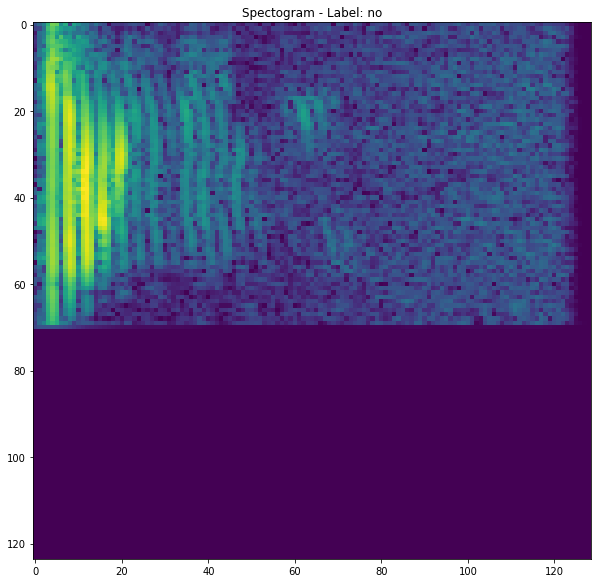

In [23]:
# Create a list of spectrograms by converting each waveform to a spectrogram.
spectrograms = []
for wave in waves:
    _, _, specgram = log_specgram(wave, sample_rate=16000)
    spectrograms.append(specgram)

spectrograms = np.array(spectrograms)

# Plot one spectrogram for visualization purposes.
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111)

# Visualize the spectrogram for index 1.
idx = 1
ax1.set_title('Spectogram - Label: {}'.format(labels[idx]))
ax1.imshow(spectrograms[idx])

In [24]:
all_data = y

In [25]:
# Using sklearn, split the spectrograms and labels into training and validation sets (80-20 ratio).
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(spectrograms),np.array(y),stratify=y,test_size = 0.2,random_state=666,shuffle=True)

In [26]:
# Create the Keras CNN model.
from keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

# All the spectrograms are 124x129 (x1 "channel", the amplitude)
inputs = Input(shape=(124, 129, 1))

# Create 4 Conv2D layers that get progressively larger filters with smaller convolutions.
conv = Conv2D(2, 5, padding='same', activation='relu', strides=1)(inputs)
conv = MaxPooling2D(2)(conv)
conv = Dropout(0.1)(conv)

conv = Conv2D(4, 3, padding='same', activation='relu', strides=1)(conv)
conv = MaxPooling2D(2)(conv)
conv = Dropout(0.1)(conv)

conv = Conv2D(8, 1, padding='same', activation='relu', strides=1)(conv)
conv = MaxPooling2D(2)(conv)
conv = Dropout(0.1)(conv)

conv = Conv2D(16, 1, padding='same', activation='relu', strides=1)(conv)
conv = MaxPooling2D(2)(conv)
conv = Dropout(0.1)(conv)

# Flatten the output of the convolution layers.
conv = Flatten()(conv)

# Create dense layers to learn the features identified by the convolutional layers.
conv = Dense(512, activation='relu')(conv)
conv = Dropout(0.1)(conv)

conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.1)(conv)

# Get our categorical outputs (probabilities) using a softmax layer.
outputs = Dense(len(classes), activation='softmax')(conv)

# Display a summary of the model.
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124, 129, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 124, 129, 2)       52        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 64, 2)         0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 64, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 64, 4)         76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 32, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 32, 4)         0     

In [28]:
# Compile the model and provide it with early stopping in case there is no improvement.
# Add checkpoints to save the data based on minimized validation loss.
model = None
if os.path.exists('best_model_augmented.hdf5'):
    model = keras.models.load_model('best_model_augmented.hdf5')
    print("Model loaded from 'best_model_augmented.hdf5'")
else:
    model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
    mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=256, validation_data=(x_val,y_val))

Model loaded from 'best_model_augmented.hdf5'


In [29]:
# Prediction function to view the result for a single input.
def predict(audio):
    prob=model.predict(audio.reshape(1, 124, 129, 1))
    index=np.argmax(prob[0])
    return classes[index]

# Randomly select an input from the validation set to check the model's prediction.
import random
print(np.shape(x_tr))
index=random.randint(0,len(x_val)-1)
samples=x_val[index]
print(np.shape(samples))
print("Audio:", classes[np.argmax(y_val[index])])

print("Text:", predict(samples))

(140, 124, 129)
(124, 129)
Audio: right
Text: right


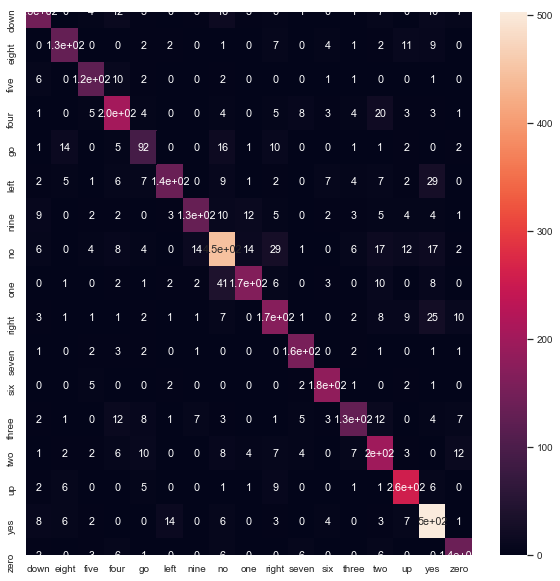

In [163]:
# Import visualization libraries to create a confusion matrix.
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

# Convert the predictions for the validation set into labels (using argmax to select the most probable output).
y_pred = [classes[y] for y in np.argmax(model.predict(x_val), axis=1)]

# Do the same for the real labels (one-hot).
y_true = [classes[y] for y in np.argmax(y_val, axis=1)]

# Print the predictions and true labels.
#print(y_pred)
#print(y_true)

# Display the confusion matrix.
cm = confusion_matrix(y_true, y_pred, labels=classes)
df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize = (10,10))
sn.set(font_scale=0.9)
sn.heatmap(df_cm, annot=True)

In [155]:
#Augmentation attempts

#Distribution of current data
dis = {}
for i in all_data:
    label = classes[np.argmax(i)]
    if label not in dis:
        dis[label] = 1
    else:
        dis[label] += 1 
print(dis)


{'up': 1452, 'no': 2904, 'one': 1210, 'two': 1331, 'go': 726, 'left': 1089, 'right': 1210, 'down': 1089, 'yes': 2783, 'three': 968, 'four': 1331, 'seven': 847, 'five': 726, 'eight': 847, 'nine': 968, 'six': 968, 'zero': 847}


In [137]:
# Function to augment audio data by varying its speed/pitch randomly.
def augment_speed(wav):
    # Choose a random speed rate between 0.7 and 1.3.
    speed_rate = np.random.uniform(0.7,1.3)

    # Stretch or squeeze the audio wave depending on the speed_rate
    wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()

    # Pad the audio (randomly) if it's too short after the augment.
    if len(wav_speed_tune) < 16000:
        pad_len = 16000 - len(wav_speed_tune)
        wav_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                            wav_speed_tune,
                            np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]

    # Otherwise, cut it to 16000 samples.
    else: 
        cut_len = len(wav_speed_tune) - 16000
        wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+16000]
    return wav_speed_tune


In [138]:
# Augment the normal waves using the augment_speed function.
speed_augmented_wavs = []
speed_augmented_y = []

# For each wave (and label), generate 10 speed-augmented variants with the same label.
for wav, yi in zip(waves, y):
    for i in range(10):
        speed_augmented_wavs.append(augment_speed(wav))
        speed_augmented_y.append(yi)

speed_augmented_wavs = np.array(speed_augmented_wavs)
speed_augmented_y = np.array(speed_augmented_y)
speed_augmented_wavs = np.concatenate((waves, speed_augmented_wavs))
speed_augmented_y = np.concatenate((y, speed_augmented_y))
print(np.shape(speed_augmented_wavs))
print(np.shape(speed_augmented_y))

(1936, 16000)
(1936, 17)


In [140]:
# Helper to run the model with the speed_augmented data.
waves = speed_augmented_wavs 
y = speed_augmented_y

In [141]:
# Function to augment audio data by adding random white noise to a wave.
def augment_noise(wav):
    # Generate an array containing random values for the length of the wave.
    wn = np.random.randn(len(wav))

    # Add it (multiplied by a small number) to the wave so we can still hear the original sound.
    data_wn = wav + 0.005*wn
    return data_wn

In [142]:
# Add white noise to waves in the same way that we did for speed (10 augmented variants per wave).
noise_augmented_wavs = []
noise_augmented_y = []
for wav, yi in zip(waves, y):
    for i in range(10):
        noise_augmented_wavs.append(augment_noise(wav))
        noise_augmented_y.append(yi)

noise_augmented_wavs = np.array(noise_augmented_wavs)
noise_augmented_y = np.array(noise_augmented_y)
noise_augmented_wavs = np.concatenate((waves, noise_augmented_wavs))
noise_augmented_y = np.concatenate((y, noise_augmented_y))
print(np.shape(noise_augmented_wavs))
print(np.shape(noise_augmented_y))

(21296, 16000)
(21296, 17)


In [150]:
# Helper to change data for the model
waves = noise_augmented_wavs
y = noise_augmented_y

In [151]:
# Helper to rebuild spectrograms after playing around with data.
spectrograms = []
for wave in waves:
    _, _, specgram = log_specgram(wave, sample_rate=16000)
    spectrograms.append(specgram)

spectrograms = np.array(spectrograms)

In [30]:
# Test the prediction with self-recorded soundclips with normal voice.
for test in ['test_six.wav', 'test_eight.wav', 'test_up.wav', 'test_down.wav', 'test_three.wav']:
    test_wav = read_audio(test, False)
    test_wav = standardize_wave(read_audio(test, False))
    _, _, test_gram = log_specgram(test_wav, sample_rate=16000)
    print("Prediction: ", predict(test_gram))


Loaded WAV file: test_six.wav. SR: 16000. Len: 12074.
Loaded WAV file: test_six.wav. SR: 16000. Len: 12074.
Prediction:  six
Loaded WAV file: test_eight.wav. SR: 16000. Len: 9845.
Loaded WAV file: test_eight.wav. SR: 16000. Len: 9845.
Prediction:  right
Loaded WAV file: test_up.wav. SR: 16000. Len: 14303.
Loaded WAV file: test_up.wav. SR: 16000. Len: 14303.
Prediction:  eight
Loaded WAV file: test_down.wav. SR: 16000. Len: 10774.
Loaded WAV file: test_down.wav. SR: 16000. Len: 10774.
Prediction:  zero
Loaded WAV file: test_three.wav. SR: 16000. Len: 10217.
Loaded WAV file: test_three.wav. SR: 16000. Len: 10217.
Prediction:  three


In [32]:
model.evaluate(spectrograms, y)

6/6 [==============================] - 0s 49ms/step - loss: 0.6111 - accuracy: 0.8182


[0.6111342906951904, 0.8181818127632141]